# 2.1 Modeling Baseline (Logistic Regression and Naive Bayes)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# -------------------------------
# STEP 0: Load Cleaned Dataset
# -------------------------------
df = pd.read_csv("../dataset/cleaned_dataset_baseline_model.csv")  # Pastikan kolomnya: 'tweet', 'sentimen'

In [3]:
# -------------------------------
# STEP 1: Apply Preprocessing
# -------------------------------
# 1. Encode label
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["sentimen"])

In [4]:
# -------------------------------
# STEP 2: Split train/test
# -------------------------------
# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_tweet"], df["label_encoded"],
    test_size=0.2, random_state=42, stratify=df["label_encoded"]
)

In [5]:
# -------------------------------
# STEP 3: TF-IDF Vectorizer
# -------------------------------
# 3. TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [6]:
# -------------------------------
# STEP 4: Training
# -------------------------------
# 4A. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

In [7]:
y_prob_nb = nb.predict_proba(X_test_vec)

In [8]:
# 4B. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)

In [9]:
y_prob_lr = lr.predict_proba(X_test_vec)

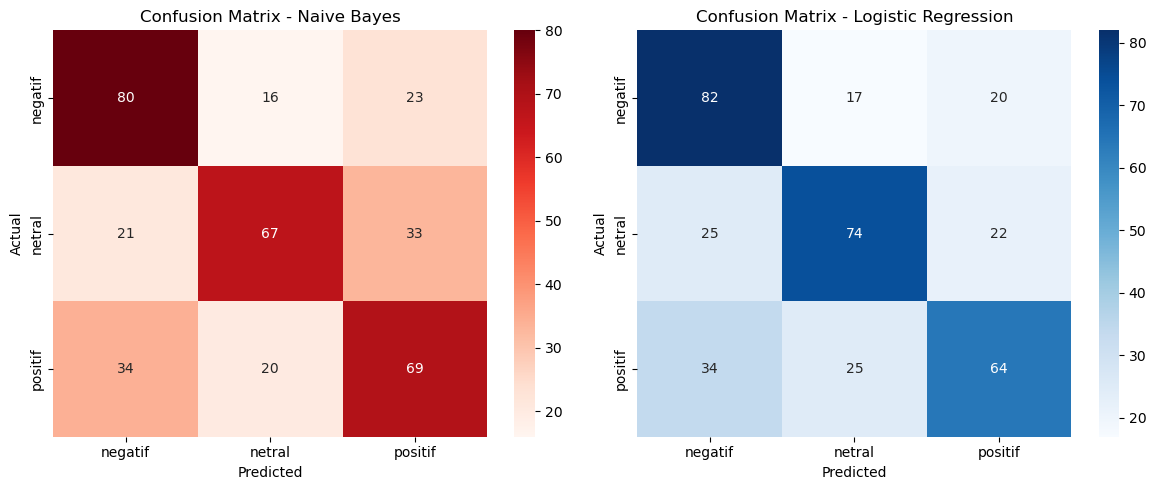

In [10]:
# -------------------------------
# STEP 5: Confusion Matrix
# -------------------------------
# 5. Confusion Matrix: Side by Side
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
labels = label_encoder.classes_

plt.figure(figsize=(12, 5))
# Naive Bayes
plt.subplot(1, 2, 1)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Logistic Regression
plt.subplot(1, 2, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Evaluation

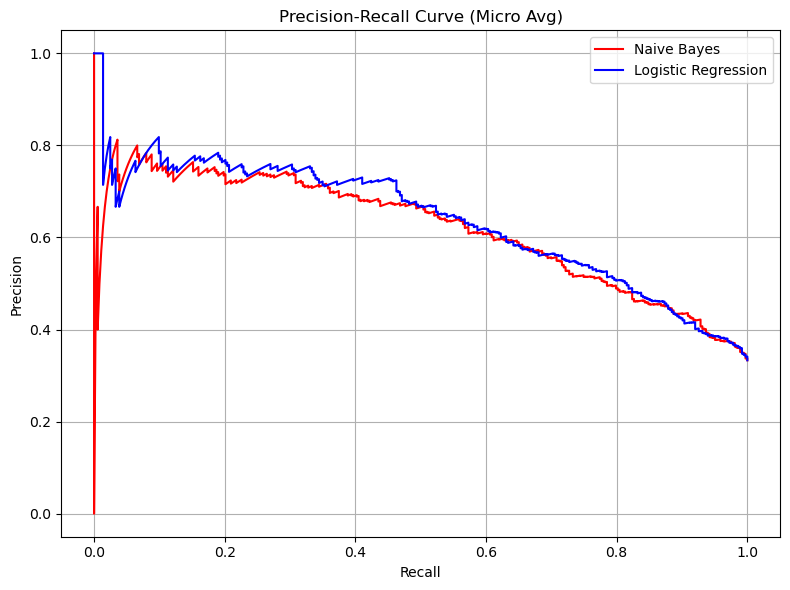

In [11]:
# -------------------------------
# STEP 6: Confusion Matrix
# -------------------------------
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

roc_auc_nb = roc_auc_score(y_test_bin, y_prob_nb, average="macro", multi_class="ovr")
roc_auc_lr = roc_auc_score(y_test_bin, y_prob_lr, average="macro", multi_class="ovr")

precision_nb = precision_score(y_test, y_pred_nb, average="macro")
precision_lr = precision_score(y_test, y_pred_lr, average="macro")

# -------------------------------
# STEP 7: Cross Validation
# -------------------------------
cv_nb = cross_val_score(nb, X_train_vec, y_train, cv=5, scoring="accuracy")
cv_lr = cross_val_score(lr, X_train_vec, y_train, cv=5, scoring="accuracy")

# -------------------------------
# STEP 8: Precision-Recall Curve
# -------------------------------
prec_nb, rec_nb, _ = precision_recall_curve(y_test_bin.ravel(), y_prob_nb.ravel())
prec_lr, rec_lr, _ = precision_recall_curve(y_test_bin.ravel(), y_prob_lr.ravel())

plt.figure(figsize=(8, 6))
plt.plot(rec_nb, prec_nb, label="Naive Bayes", color="red")
plt.plot(rec_lr, prec_lr, label="Logistic Regression", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Micro Avg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve.png")
plt.show()

---

### 🔵 **Logistic Regression**

* Lebih stabil sepanjang rentang recall
* Menjaga precision tetap tinggi (sekitar 0.75–0.85) hingga recall \~0.5
* Kurva lebih **menggantung ke kanan atas**, artinya **lebih kuat dalam memprediksi sentimen minoritas**

### 🔴 **Naive Bayes**

* Kurva lebih fluktuatif di area low recall
* Precision drop lebih cepat dibanding LogReg
* Cocok untuk baseline, tapi cenderung oversimplified

---

## 📊 **Rangkuman Evaluasi Model Baseline:**

| Aspek                         | Naive Bayes                     | Logistic Regression  |
| ----------------------------- | ------------------------------- | -------------------- |
| **ROC-AUC (Macro)**           | ✅ Sedang                        | ✅ Lebih tinggi       |
| **Precision (Macro Avg)**     | ❗ Cukup (misclassify minoritas) | ✅ Baik dan stabil    |
| **Cross-Validation Accuracy** | Sedikit lebih rendah            | Lebih stabil         |
| **PR Curve (Visual)**         | Fluktuatif                      | Konsisten dan unggul |

---


In [12]:
# ============================================
# STEP 7: Save Models & Vectorizer
# ============================================
with open("../models/baseline model/naive_bayes_model.pkl", "wb") as f:
    pickle.dump(nb, f)
with open("../models/baseline model/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(lr, f)
with open("../models/baseline model/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [13]:
# ============================================
# STEP 8: Output Summary
# ============================================
print("📊 ROC-AUC")
print(f"Naive Bayes        : {roc_auc_nb:.4f}")
print(f"Logistic Regression: {roc_auc_lr:.4f}\n")

print("🎯 Precision (Macro)")
print(f"Naive Bayes        : {precision_nb:.4f}")
print(f"Logistic Regression: {precision_lr:.4f}\n")

print("📈 Cross-Validation Accuracy")
print(f"Naive Bayes        : {cv_nb.mean():.4f} ± {cv_nb.std():.4f}")
print(f"Logistic Regression: {cv_lr.mean():.4f} ± {cv_lr.std():.4f}")

📊 ROC-AUC
Naive Bayes        : 0.7716
Logistic Regression: 0.7794

🎯 Precision (Macro)
Naive Bayes        : 0.5984
Logistic Regression: 0.6078

📈 Cross-Validation Accuracy
Naive Bayes        : 0.6164 ± 0.0297
Logistic Regression: 0.6184 ± 0.0265
